<a href="https://www.kaggle.com/code/mrafraim/dl-day-22-cnn-in-pytorch?scriptVersionId=289814155" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Day 22: CNN in PyTorch

Welcome to Day 22!

Today you'll learn:
- Load MNIST dataset using PyTorch
- Build a simple CNN architecture
- Understand tensor shapes at each layer
- Train and evaluate the CNN

If you found this notebook helpful, your **<b style="color:red;">UPVOTE</b>** would be greatly appreciated! It helps others discover the work and supports continuous improvement.

---

# Import Necessary Libraries

In [1]:
import torch                   # Core PyTorch library: tensor operations + autograd engine
import torch.nn as nn          # Neural network modules (layers, loss functions, model base class)
import torch.optim as optim    # Optimization algorithms (SGD, Adam, RMSprop, etc.)

from torchvision import datasets, transforms  
# datasets   → ready-made datasets (MNIST, CIFAR, ImageNet, etc.)
# transforms → data preprocessing & augmentation (ToTensor, Normalize, Resize, etc.)

from torch.utils.data import DataLoader  
# DataLoader → efficient batching, shuffling, and parallel data loading during training

import matplotlib.pyplot as plt  # Visualize images

# Decide Whether to Use GPU or CPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# MNIST Dataset

MNIST stands for Modified National Institute of Standards and Technology dataset.
It was created from a larger collection of handwritten digits originally gathered by the U.S. National Institute of Standards and Technology (NIST).

Each digit image was carefully cleaned, centered, and resized to 28 × 28 grayscale pixels, making the dataset simple, consistent, and easy to model. With 70,000 images split into 60,000 for training and 10,000 for testing, MNIST became the go-to dataset for teaching and validating image classification algorithms.

Because of its simplicity and balance, MNIST is widely used as a first benchmark in machine learning helping researchers and practitioners verify that their models, pipelines, and training logic work correctly.

- 70,000 grayscale images
- Digits: 0 – 9
- Image size: 28 × 28
- Single channel (not RGB)

Split:
- Training: 60,000
- Test: 10,000

# Preprocessing Pipeline

In [3]:
transform = transforms.Compose([                
    transforms.ToTensor(),                      # Converts image to tensor, scale [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

`transforms.Compose([...])`

* **Purpose:** Chains multiple image transformations together.
* **Why:** You often want to do several preprocessing steps (convert to tensor → normalize → resize, etc.) in one pipeline.
* **Flow:** Each image passes through each step in order.


`transforms.ToTensor()`

* Converts an image from *PIL format or NumPy array → PyTorch tensor
* Changes shape: `(H, W)` → `(C, H, W)` (PyTorch expects channel-first)
* Scales pixel values from `[0, 255]` → `[0.0, 1.0]` automatically

Example

```
Original pixel: 128  → ToTensor() → 128 / 255 ≈ 0.502
```

`transforms.Normalize(mean, std)`

* Formula:

$$
x_{\text{normalized}} = \frac{x - \text{mean}}{\text{std}}
$$

* For MNIST: `mean = 0.1307`, `std = 0.3081`
* **Purpose:**

  1. Centers pixel values around 0
  2. Scales variance to ~1
* **Why it matters:**

  * Faster training convergence
  * More stable gradients
  * Standard practice in deep learning

**Example:**

* Pixel after `ToTensor()`: 0.5
* Normalized:
  $$
  (0.5 - 0.1307) / 0.3081 ≈ 1.21
  $$
  


```
MNIST image file
      ↓
   PIL Image (image object)       ← "just a picture"
      ↓ ToTensor()
   Tensor                   ← "numbers the model can learn from"
      ↓ Normalize()
   Ready for CNN
```

*PIL = Python’s way of holding an image before math happens

Just like:
- Text file → string
- CSV file → table
- Image file → PIL Image

# Load MNIST Dataset with Preprocessing


In [4]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 987kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


# Wrap Datasets in DataLoader for Batching & Shuffling

In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False)


# Let’s See What the Images Look Like


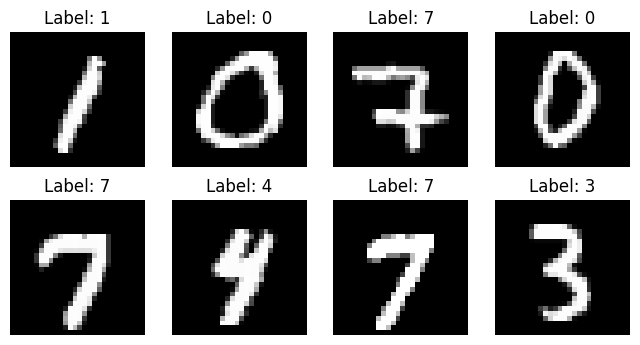

In [6]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()


# Check Image Shape
CNN expects images as (batch_size, channels, height, width)

In [7]:
images.shape


torch.Size([64, 1, 28, 28])

# CNN Architecture

1. **Convolution:** Extract features (edges, shapes)  
2. **ReLU:** Add non-linearity  
3. **MaxPooling:** Reduce spatial dimensions  
4. **Flatten:** Convert to vector  
5. **Fully Connected Layer:** Predict class


```
Input Image (e.g., 28×28 MNIST)
        │
        ▼
Convolution Layer
- Applies learnable filters
- Extracts local features (edges, curves, textures)
        │
        ▼
ReLU Activation
- Introduces non-linearity
- Keeps positive signals, suppresses noise
        │
        ▼
Max Pooling
- Downsamples feature maps
- Retains most important activations
        │
        ▼
Flatten
- Converts 2D feature maps into 1D vector
        │
        ▼
Fully Connected Layer
- Combines learned features
- Outputs class probabilities


# Define CNN

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):                    # Initialization: setting up the building blocks
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Activation function 
        self.relu = nn.ReLU()
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # (in_features, out_features)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):                 # Forward Pass: defines how the input flows through the network
        x = self.relu(self.conv1(x))  # (N,16,28,28)
        x = self.pool(x)              # (N,16,14,14)

        x = self.relu(self.conv2(x))  # (N,32,14,14)
        x = self.pool(x)              # (N,32,7,7)

        x = x.view(x.size(0), -1)     # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)               # output of shape (batch_size, 10)

        return x


## Initialization

**Purpose:**

This part declares and initializes all the layers your CNN will use.

- Think of it as “setting up the building blocks”.
- At this point, no data is processed yet, it’s just defining the model’s structure:
- Convolutional layers → feature extraction
- Pooling → downsampling
- ReLU → non-linearity
- Fully connected layers → classification

**1. Model Definition & Initialization**

```python
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
````
* `class SimpleCNN(nn.Module)` defines a new class called SimpleCNN.
* `nn.Module` is the base class for all PyTorch models.
* `def __init__(self)` Constructor of the class. Runs once when you create an object. `self` → refers to this specific neuron object.
* `super().__init__()` initializes internal PyTorch machinery (parameters, gradients, etc.).

**2. Convolution Layers (Feature Extraction)**

```python
self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
```

* **`nn.Conv2d`**: Applies a 2D convolution over an image (or batch of images). Think of it as a filter sliding over the image, detecting features like edges or patterns.
* **Parameters explained**:

  1. `in_channels`: Number of input channels. MNIST images are grayscale → `1`. If it were RGB → `3`.
  2. `out_channels`: Number of filters (feature maps) to learn.

     * `conv1` outputs 16 feature maps.
     * `conv2` outputs 32 feature maps.
  3. `kernel_size=3`: Filter size 3×3.
  4. `padding=1`: Adds a 1-pixel border around the input so the output size remains the same after convolution (important to control dimensions).

Why convolution?

To detect local patterns like edges, curves, and shapes.

**3. Activation Function (ReLU)**

```python
self.relu = nn.ReLU()
```

* Applies:
  $$
  f(x) = \max(0, x)
  $$
* Introduces non-linearity
* Prevents the network from collapsing into a linear model

**4. Pooling Layer**

```python
self.pool = nn.MaxPool2d(2, 2)
```

* **`nn.MaxPool2d`**: Reduces spatial dimensions (height & width) by taking the maximum value in each window.
* **Parameters**:

  * `2, 2` → window size 2×2, stride 2 → halves the dimensions.
* Helps reduce computation and introduces translation invariance (small shifts in the image don’t change the output much).

Example:

```
28×28 → 14×14 → 7×7
```

Why pooling?

* Reduces computation
* Makes features more robust to small shifts
* Keeps strongest activations


**5. Fully Connected Layers**

```python
self.fc1 = nn.Linear(32 * 7 * 7, 128)
self.fc2 = nn.Linear(128, 10)
```

* After convolutions and pooling, the feature maps are flattened into a 1D vector to feed into fully connected (dense) layers.
* **Dimensions**:

  * Input image: 28×28
  * After `conv1` + ReLU → 28×28×16
  * After `pool` → 14×14×16
  * After `conv2` + ReLU → 14×14×32
  * After `pool` → 7×7×32
  * Flattened → 32×7×7 = 1568 features → fed into `fc1`
* `fc1` reduces 1568 → 128 features.
* `fc2` maps 128 → 10, which corresponds to 10 classes in MNIST (digits 0–9).

## Forward Pass

**Purpose:**

This part defines how the input flows through the network, the actual computation.

- It applies the layers you defined in a specific order:
- Conv → ReLU → Pool
- Conv → ReLU → Pool
- Flatten → FC → ReLU → FC → Output
- Returns the logits (raw scores) for each class.

**What `forward()` REALLY is**

`forward()` defines how data flows through the network.

Think of it as an assembly line:
raw pixels → feature extractor → compressor → decision maker.

PyTorch will automatically:

* call this during training/inference
* compute gradients through it (autograd)


**Input: `x`**

For MNIST:

```
x shape = (batch_size, 1, 28, 28)
```

* `batch_size`: number of images processed together
* `1`: grayscale channel
* `28×28`: image size


**1. First Convolution + Activation**

```python
x = self.relu(self.conv1(x))
```

What happens

* `conv1`: applies 16 different 3×3 filters
* Each filter learns something different (edges, curves, strokes)
* `ReLU`: removes negative values → keeps useful signal

Shape change:

```
( batch, 1, 28, 28 )
→ conv1 →
( batch, 16, 28, 28 )
→ ReLU →
( batch, 16, 28, 28 )
```

Padding = 1 → spatial size stays 28×28


**2️. First Pooling**

```python
x = self.pool(x)
```

What pooling does

* Takes the max value in every 2×2 block
* Reduces spatial size
* Keeps the strongest activations

Shape change:

```
( batch, 16, 28, 28 )
→ MaxPool(2×2) →
( batch, 16, 14, 14 )
```

This is where the model throws away redundancy.


**3️. Second Convolution + Activation**

```python
x = self.relu(self.conv2(x))
```

What changes here

* Input channels = 16
* Output channels = 32
* Model now learns higher-level features

  * not edges anymore
  * combinations of edges → digit parts

Shape change:

```
( batch, 16, 14, 14 )
→ conv2 →
( batch, 32, 14, 14 )
→ ReLU →
( batch, 32, 14, 14 )
```

**4️. Second Pooling**

```python
x = self.pool(x)
```

Shape change:

```
( batch, 32, 14, 14 )
→ MaxPool →
( batch, 32, 7, 7 )
```

Now each image is represented by 32 feature maps of size 7×7.

This is the end of feature extraction.


**5️. Flattening**

```python
x = x.view(x.size(0), -1)
```

Why this is needed

Fully connected layers expect 2D input:

```
(batch_size, features)
```

What this line does

* `x.size(0)` → batch size (DON’T touch it)
* `-1` → “infer the rest automatically”

Shape change:

```
( batch, 32, 7, 7 )
→ flatten →
( batch, 32*7*7 )
→ ( batch, 1568 )
```

This number must match `fc1` input size
That’s why you defined:

```python
nn.Linear(32*7*7, 128)
```


**6️. First Fully Connected Layer**

```python
x = self.relu(self.fc1(x))
```

What happens

* Compresses 1568 features → 128
* ReLU adds non-linearity

Shape:

```
( batch, 1568 )
→ fc1 →
( batch, 128 )
```

This is where reasoning happens.


**7.Output Layer (No ReLU!)**

```python
x = self.fc2(x)
```

Why no ReLU here?

Because:

* This outputs raw scores (logits). Logits = output of the final fully connected layer before applying softmax or any probability function.
* Loss functions like `CrossEntropyLoss` expect logits

Shape:

```
( batch, 128 )
→ fc2 →
( batch, 10 )
```

Each row:

```
[ score_0, score_1, ..., score_9 ]
```

The highest score = predicted digit.


**8️. Return Output**

```python
return x
```

This goes to:

* loss function (during training)
* `argmax` (during inference)

# Model, Loss, Optimizer

In [9]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 1️. Cross-Entropy Loss

Cross-Entropy Loss is used for multi-class classification. It measures how close the predicted probabilities are to the true labels.

**Step 1: Softmax to get probabilities**

For a network output (logits) $z = [z_0, z_1, ..., z_{C-1}]$ for $C$ classes:

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=0}^{C-1} e^{z_j}}, \quad i = 0, 1, ..., C-1
$$

- $\hat{y}_i$ = predicted probability for class $i$  


**Step 2: Cross-Entropy for one sample**

If the true label is $y$:

$$
\text{Loss} = - \log(\hat{y}_y)
$$

- Only the probability of the true class contributes  
- Penalizes incorrect predictions  

**Step 3: Average over a batch of $N$ samples**

$$
\text{CrossEntropyLoss} = - \frac{1}{N} \sum_{n=1}^{N} \log(\hat{y}_{y^{(n)}})
$$

- Smaller loss → better predictions  
- Encourages high probability for the correct class  


## 2️. Adam Optimizer

Adam combines momentum + RMSProp for efficient gradient updates.

**Step 1: Compute gradients**

$$
g_t = \nabla_\theta L_t
$$

- Gradient of the loss w.r.t. parameters $\theta$ at step $t$  


**Step 2: Update biased first and second moments**

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$

- $m_t$ = momentum (moving average of gradients)  
- $v_t$ = adaptive scaling (moving average of squared gradients)  


**Step 3: Bias correction**

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad 
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

- Corrects initialization bias at early steps  


**Step 4: Parameter update**

$$
\theta_t = \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

- $\eta$ = learning rate  
- $\epsilon$ = small constant to avoid division by zero  
- Automatically scales updates per parameter for stable and fast convergence  


### Summary Table

| Component | Formula | Role |
|-----------|--------|------|
| Cross-Entropy Loss | $L = -\frac{1}{N} \sum_{n=1}^{N} \log \hat{y}_{y^{(n)}}$ | Measures how well predictions match true labels |
| Adam Optimizer | $\theta_t = \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$ | Updates weights efficiently using momentum + adaptive scaling |


# Training Loop

In [10]:
def train(model, loader):
    model.train()                          # Set model to training mode
    total_loss = 0                         # Initialize cumulative loss for the epoch

    # Loop over each batch of images and labels in the DataLoader
    for images, labels in loader:     
        images, labels = images.to(device), labels.to(device) # Move data to the appropriate device (CPU or GPU)

        optimizer.zero_grad()              # Clear old gradients
        outputs = model(images)            # Forward pass: compute predictions from the model
        loss = criterion(outputs, labels)  # Compute the loss between predictions and true labels
        loss.backward()                    # Backward pass: compute gradients of loss w.r.t. model parameters
        optimizer.step()                   # Update model parameters using gradients (Adam)

        total_loss += loss.item()          # Accumulate the batch loss (convert tensor to scalar)

    return total_loss / len(loader)        # Return average loss over all batches in the epoch


# Evaluation Loop

In [11]:
def evaluate(model, loader):
    model.eval()                                             # Set model to evaluation mode
    correct = 0                                              # Counters for correct predictions and total samples
    total = 0

    # No gradients needed during evaluation → saves memory & computation
    with torch.no_grad():
        for images, labels in loader:                        # Loop over each batch in the DataLoader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                           # Forward pass: compute predictions from the model
            predictions = outputs.argmax(dim=1)               # Get predicted class by taking the index of the highest logit

            correct += (predictions == labels).sum().item()   # Count correct predictions in this batch
            total += labels.size(0)                           # Count total samples processed

    return correct / total                                    # Compute overall accuracy


# Train the CNN

In [12]:
epochs = 5

for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")


Epoch 1/5 | Loss: 0.1551 | Accuracy: 0.9826
Epoch 2/5 | Loss: 0.0515 | Accuracy: 0.9868
Epoch 3/5 | Loss: 0.0351 | Accuracy: 0.9875
Epoch 4/5 | Loss: 0.0263 | Accuracy: 0.9883
Epoch 5/5 | Loss: 0.0201 | Accuracy: 0.9880


# What the CNN Learned

- Conv1 → edges & simple patterns  
- Conv2 → digit-specific shapes  
- FC layers → combine features → classify


# Key Takeaways from Day 22

- CNNs work on patterns, not raw numbers  
- Input shape must be (N, C, H, W)  
- Convolutions extract features hierarchically  
- Pooling reduces spatial size  
- PyTorch simplifies training & evaluation

---

<p style="text-align:center; font-size:18px;">
© 2026 Mostafizur Rahman
</p>
